# Random Forest สำหรับทำนายราคาน้ำมัน Brent
คู่ทำ คือ
1. มาวิน
2. โต๋เต๋

## วัตถุประสงค์
ใช้ Random Forest  ในการทำนายราคาน้ำมันดิบ Brent ในวันถัดไป
โดยใช้ข้อมูลราคาย้อนหลังของน้ำมัน Brent และ WTI

## 1. Import Libraries

In [24]:
import sys
#sys.stdout.reconfigure(encoding='utf-8')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("  Random Forest Model - Oil Price Prediction")
print("=" * 60)


  Random Forest Model - Oil Price Prediction


## 2. โหลดและสำรวจข้อมูล

In [25]:
print("\n" + "=" * 60)
print("  Part 2: โหลดและสำรวจข้อมูล")
print("=" * 60)

# กำหนด path ของไฟล์ข้อมูล
base_path = r"c:\Users\mawin\OneDrive\Desktop\project AI\Oil-Price-Prediction\data"

# โหลดข้อมูลจาก 3 ไฟล์
merged_df = pd.read_csv(f"{base_path}/processed/merged_oil_prices.csv")
brent_df = pd.read_csv(f"{base_path}/raw/brent_prices.csv")
wti_df = pd.read_csv(f"{base_path}/raw/wti_prices.csv")

# --- 2.1 สำรวจ merged_oil_prices.csv ---
print("\n--- merged_oil_prices.csv ---")
print(f"Shape: {merged_df.shape}")
print(f"\nColumns: {list(merged_df.columns)}")
print(f"\nFirst 5 rows:")
print(merged_df.head())
print(f"\nข้อมูลทั่วไป:")
print(merged_df.info())
print(f"\nสถิติเบื้องต้น:")
print(merged_df.describe())

# --- 2.2 สำรวจ brent_prices.csv ---
print("\n--- brent_prices.csv ---")
print(f"Shape: {brent_df.shape}")
print(f"\nColumns: {list(brent_df.columns)}")
print(f"\nFirst 5 rows:")
print(brent_df.head())

# --- 2.3 สำรวจ wti_prices.csv ---
print("\n--- wti_prices.csv ---")
print(f"Shape: {wti_df.shape}")
print(f"\nColumns: {list(wti_df.columns)}")
print(f"\nFirst 5 rows:")
print(wti_df.head())

# --- 2.4 ตรวจสอบค่า Missing ---
print("\n--- ตรวจสอบ Missing Values ---")
print("\nmerged_oil_prices:")
print(merged_df.isnull().sum())
print("\nbrent_prices:")
print(brent_df.isnull().sum())
print("\nwti_prices:")
print(wti_df.isnull().sum())

# แปลงคอลัมน์ date เป็น datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])
brent_df['date'] = pd.to_datetime(brent_df['date'])
wti_df['date'] = pd.to_datetime(wti_df['date'])

# เรียงตามวันที่
merged_df = merged_df.sort_values('date').reset_index(drop=True)
brent_df = brent_df.sort_values('date').reset_index(drop=True)
wti_df = wti_df.sort_values('date').reset_index(drop=True)

print(f"\nช่วงวันที่ merged_df: {merged_df['date'].min()} ถึง {merged_df['date'].max()}")
print(f"ช่วงวันที่ brent_df : {brent_df['date'].min()} ถึง {brent_df['date'].max()}")
print(f"ช่วงวันที่ wti_df   : {wti_df['date'].min()} ถึง {wti_df['date'].max()}")


  Part 2: โหลดและสำรวจข้อมูล

--- merged_oil_prices.csv ---
Shape: (1846, 13)

Columns: ['date', 'open_x', 'high_x', 'low_x', 'close_x', 'volume_x', 'average_x', 'open_y', 'high_y', 'low_y', 'close_y', 'volume_y', 'average_y']

First 5 rows:
        date  open_x  high_x  low_x  close_x  volume_x  average_x  open_y  \
0  11/2/2017   56.73   56.73  56.73    56.73         0      56.73   51.32   
1  11/3/2017   56.84   56.84  56.84    56.84         0      56.84   51.39   
2  11/6/2017   57.26   57.26  57.26    57.26         0      57.26   51.07   
3  11/7/2017   57.40   57.40  57.40    57.40         0      57.40   51.43   
4  11/8/2017   58.17   58.17  58.17    58.17         0      58.17   52.22   

   high_y  low_y  close_y  volume_y  average_y  
0   51.32  51.32    51.32         0      51.32  
1   51.39  51.39    51.39         0      51.39  
2   51.07  51.07    51.07         0      51.07  
3   51.43  51.43    51.43         0      51.43  
4   52.22  52.22    52.22         0      52.22  


## 3. Feature Engineering

สร้าง features สำหรับการทำนาย:
- Lagged features: ราคาย้อนหลัง 1, 3, 5, 7 วัน
- Moving averages: ค่าเฉลี่ย 5 และ 10 วัน
- Target: ราคา Brent วันถัดไป

In [26]:
print("\n" + "=" * 60)
print("  Part 3: Feature Engineering")
print("=" * 60)

# ใช้ merged_oil_prices เป็นข้อมูลหลัก
# คอลัมน์ _x = Brent, _y = WTI
df = merged_df.copy()

# --- 3.1 Lagged Features: ราคาย้อนหลัง 1, 3, 5, 7 วัน ---
print("\nสร้าง Lagged Features...")
for lag in [1, 3, 5, 7]:
    df[f'brent_close_lag_{lag}'] = df['close_x'].shift(lag)
    df[f'wti_close_lag_{lag}'] = df['close_y'].shift(lag)
    df[f'brent_volume_lag_{lag}'] = df['volume_x'].shift(lag)

print("  - brent_close_lag_1, brent_close_lag_3, brent_close_lag_5, brent_close_lag_7")
print("  - wti_close_lag_1, wti_close_lag_3, wti_close_lag_5, wti_close_lag_7")
print("  - brent_volume_lag_1, brent_volume_lag_3, brent_volume_lag_5, brent_volume_lag_7")

# --- 3.2 Moving Averages: ค่าเฉลี่ย 5 และ 10 วัน ---
print("\nสร้าง Moving Averages...")
df['brent_close_ma_5'] = df['close_x'].rolling(window=5).mean()
df['brent_close_ma_10'] = df['close_x'].rolling(window=10).mean()
df['wti_close_ma_5'] = df['close_y'].rolling(window=5).mean()
df['wti_close_ma_10'] = df['close_y'].rolling(window=10).mean()

print("  - brent_close_ma_5, brent_close_ma_10")
print("  - wti_close_ma_5, wti_close_ma_10")

# --- 3.3 Features เพิ่มเติม ---
print("\nสร้าง Features เพิ่มเติม...")
df['brent_high_low_diff'] = df['high_x'] - df['low_x']
df['wti_high_low_diff'] = df['high_y'] - df['low_y']
df['brent_open_close_diff'] = df['close_x'] - df['open_x']
df['brent_wti_spread'] = df['close_x'] - df['close_y']

print("  - brent_high_low_diff (ส่วนต่าง High-Low ของ Brent)")
print("  - wti_high_low_diff (ส่วนต่าง High-Low ของ WTI)")
print("  - brent_open_close_diff (ส่วนต่าง Close-Open ของ Brent)")
print("  - brent_wti_spread (ส่วนต่างราคา Brent-WTI)")

# --- 3.4 Target: ราคา Brent วันถัดไป ---
print("\nสร้าง Target Variable...")
df['target_brent_next_day'] = df['close_x'].shift(-1)
print("  - target_brent_next_day (ราคาปิด Brent วันถัดไป)")

# --- 3.5 ลบแถวที่มี NaN (จาก lag และ rolling) ---
df_clean = df.dropna().reset_index(drop=True)
print(f"\nจำนวนข้อมูลก่อนทำความสะอาด: {len(df)}")
print(f"จำนวนข้อมูลหลังทำความสะอาด: {len(df_clean)}")

# แสดง features ทั้งหมด
feature_cols = [
    # Lagged features - Brent
    'brent_close_lag_1', 'brent_close_lag_3', 'brent_close_lag_5', 'brent_close_lag_7',
    # Lagged features - WTI
    'wti_close_lag_1', 'wti_close_lag_3', 'wti_close_lag_5', 'wti_close_lag_7',
    # Lagged features - Volume
    'brent_volume_lag_1', 'brent_volume_lag_3', 'brent_volume_lag_5', 'brent_volume_lag_7',
    # Moving averages
    'brent_close_ma_5', 'brent_close_ma_10',
    'wti_close_ma_5', 'wti_close_ma_10',
    # Price differences
    'brent_high_low_diff', 'wti_high_low_diff',
    'brent_open_close_diff', 'brent_wti_spread',
    # Original features
    'open_x', 'high_x', 'low_x', 'close_x', 'volume_x', 'average_x',
    'open_y', 'high_y', 'low_y', 'close_y', 'volume_y', 'average_y',
]

target_col = 'target_brent_next_day'

print(f"\nจำนวน Features ทั้งหมด: {len(feature_cols)}")
print(f"Features: {feature_cols}")



  Part 3: Feature Engineering

สร้าง Lagged Features...
  - brent_close_lag_1, brent_close_lag_3, brent_close_lag_5, brent_close_lag_7
  - wti_close_lag_1, wti_close_lag_3, wti_close_lag_5, wti_close_lag_7
  - brent_volume_lag_1, brent_volume_lag_3, brent_volume_lag_5, brent_volume_lag_7

สร้าง Moving Averages...
  - brent_close_ma_5, brent_close_ma_10
  - wti_close_ma_5, wti_close_ma_10

สร้าง Features เพิ่มเติม...
  - brent_high_low_diff (ส่วนต่าง High-Low ของ Brent)
  - wti_high_low_diff (ส่วนต่าง High-Low ของ WTI)
  - brent_open_close_diff (ส่วนต่าง Close-Open ของ Brent)
  - brent_wti_spread (ส่วนต่างราคา Brent-WTI)

สร้าง Target Variable...
  - target_brent_next_day (ราคาปิด Brent วันถัดไป)

จำนวนข้อมูลก่อนทำความสะอาด: 1846
จำนวนข้อมูลหลังทำความสะอาด: 1836

จำนวน Features ทั้งหมด: 32
Features: ['brent_close_lag_1', 'brent_close_lag_3', 'brent_close_lag_5', 'brent_close_lag_7', 'wti_close_lag_1', 'wti_close_lag_3', 'wti_close_lag_5', 'wti_close_lag_7', 'brent_volume_lag_1', 'brent

## 4. เตรียมข้อมูลสำหรับ Training

In [27]:
print("\n" + "=" * 60)
print("  Part 4: เตรียมข้อมูลสำหรับ Training")
print("=" * 60)

X = df_clean[feature_cols]
y = df_clean[target_col]

# แบ่งข้อมูล Train/Test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"\nขนาด Training set : {X_train.shape}")
print(f"ขนาด Testing set  : {X_test.shape}")
print(f"\nช่วง Training: index {X_train.index[0]} - {X_train.index[-1]}")
print(f"ช่วง Testing : index {X_test.index[0]} - {X_test.index[-1]}")




  Part 4: เตรียมข้อมูลสำหรับ Training

ขนาด Training set : (1468, 32)
ขนาด Testing set  : (368, 32)

ช่วง Training: index 0 - 1467
ช่วง Testing : index 1468 - 1835


## 5. สร้างและ Train Neural Network Model

In [28]:
# ======================= Part 5: สร้างและ Train Random Forest Model ===========
print("\n" + "=" * 60)
print("  Part 5: สร้างและ Train Random Forest Model")
print("=" * 60)

# สร้าง Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

print("\nModel Configuration:")
print(f"  - n_estimators    : 100")
print(f"  - max_depth       : None (ไม่จำกัด)")
print(f"  - min_samples_split: 2")
print(f"  - min_samples_leaf : 1")
print(f"  - random_state    : 42")
print(f"  - n_jobs          : -1 (ใช้ทุก CPU cores)")

# Train model
print("\nกำลัง Training Model...")
rf_model.fit(X_train, y_train)
print("Training เสร็จสิ้น!")


  Part 5: สร้างและ Train Random Forest Model

Model Configuration:
  - n_estimators    : 100
  - max_depth       : None (ไม่จำกัด)
  - min_samples_split: 2
  - min_samples_leaf : 1
  - random_state    : 42
  - n_jobs          : -1 (ใช้ทุก CPU cores)

กำลัง Training Model...
Training เสร็จสิ้น!


## 6. ประเมินผลลัพธ์ของโมเดล

In [33]:
print("\n" + "=" * 60)
print("  Part 6: ประเมินผล Model")
print("=" * 60)

# ทำนายข้อมูล Test set
y_pred = rf_model.predict(X_test)

# คำนวณ metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\n--- ผลการประเมิน ---")
print(f"  MAE  (Mean Absolute Error)     : {mae:.4f} USD")
print(f"  MSE  (Mean Squared Error)      : {mse:.4f}")
print(f"  RMSE (Root Mean Squared Error) : {rmse:.4f} USD")
print(f"  R²   (R-squared Score)         : {r2:.4f}")
print(f"  Accuracy (1 - MAPE)            : {(1 - mae / y_test.mean()) * 100:.2f}%")



  Part 6: ประเมินผล Model

--- ผลการประเมิน ---
  MAE  (Mean Absolute Error)     : 0.8200 USD
  MSE  (Mean Squared Error)      : 1.1129
  RMSE (Root Mean Squared Error) : 1.0549 USD
  R²   (R-squared Score)         : 0.8853
  Accuracy (1 - MAPE)            : 98.91%


# 7. ตัวอย่างการทำนาย

In [31]:
print("\n" + "=" * 60)
print("  Part 7: ตัวอย่างการทำนาย")
print("=" * 60)

# ใช้ข้อมูลล่าสุดในการทำนาย
latest_data = df_clean[feature_cols].iloc[-1:]
latest_date = df_clean['date'].iloc[-1]
latest_actual = df_clean['close_x'].iloc[-1]

prediction = rf_model.predict(latest_data)[0]

print(f"\n--- ทำนายราคา Brent วันถัดไป ---")
print(f"  วันที่ข้อมูลล่าสุด       : {latest_date.strftime('%Y-%m-%d')}")
print(f"  ราคาปิด Brent วันนี้     : {latest_actual:.2f} USD")
print(f"  ราคาทำนาย Brent วันถัดไป : {prediction:.2f} USD")
print(f"  การเปลี่ยนแปลง           : {prediction - latest_actual:+.2f} USD ({((prediction - latest_actual) / latest_actual) * 100:+.2f}%)")

# แสดง input features ที่ใช้ในการทำนาย
print(f"\n--- Input Features ที่ใช้ ---")
for col in feature_cols:
    print(f"  {col:30s} : {latest_data[col].values[0]:.4f}")



  Part 7: ตัวอย่างการทำนาย

--- ทำนายราคา Brent วันถัดไป ---
  วันที่ข้อมูลล่าสุด       : 2025-04-02
  ราคาปิด Brent วันนี้     : 73.77 USD
  ราคาทำนาย Brent วันถัดไป : 74.29 USD
  การเปลี่ยนแปลง           : +0.52 USD (+0.70%)

--- Input Features ที่ใช้ ---
  brent_close_lag_1              : 74.4300
  brent_close_lag_3              : 72.4100
  brent_close_lag_5              : 73.3100
  brent_close_lag_7              : 72.4100
  wti_close_lag_1                : 70.6900
  wti_close_lag_3                : 68.6000
  wti_close_lag_5                : 69.5000
  wti_close_lag_7                : 68.6900
  brent_volume_lag_1             : 8661.0000
  brent_volume_lag_3             : 6362.0000
  brent_volume_lag_5             : 6358.0000
  brent_volume_lag_7             : 3336.0000
  brent_close_ma_5               : 73.7280
  brent_close_ma_10              : 73.0240
  wti_close_ma_5                 : 69.9740
  wti_close_ma_10                : 69.2750
  brent_high_low_diff            : 1.7500
  w


บันทึกกราฟผลลัพธ์ที่: rf_oil_prediction_results.png

--- Feature Importance (เรียงจากมากไปน้อย) ---
  average_x                      : 0.222638
  high_x                         : 0.218380
  close_x                        : 0.178419
  open_x                         : 0.177010
  low_x                          : 0.117553
  average_y                      : 0.025927
  high_y                         : 0.018792
  low_y                          : 0.018273
  open_y                         : 0.009631
  brent_close_ma_5               : 0.004761
  close_y                        : 0.002026
  brent_close_lag_1              : 0.001065
  brent_close_ma_10              : 0.000950
  wti_close_lag_1                : 0.000536
  wti_close_ma_5                 : 0.000508
  brent_wti_spread               : 0.000489
  brent_close_lag_5              : 0.000456
  brent_close_lag_3              : 0.000448
  brent_close_lag_7              : 0.000439
  wti_close_lag_5                : 0.000384
  wti_close_lag_3  

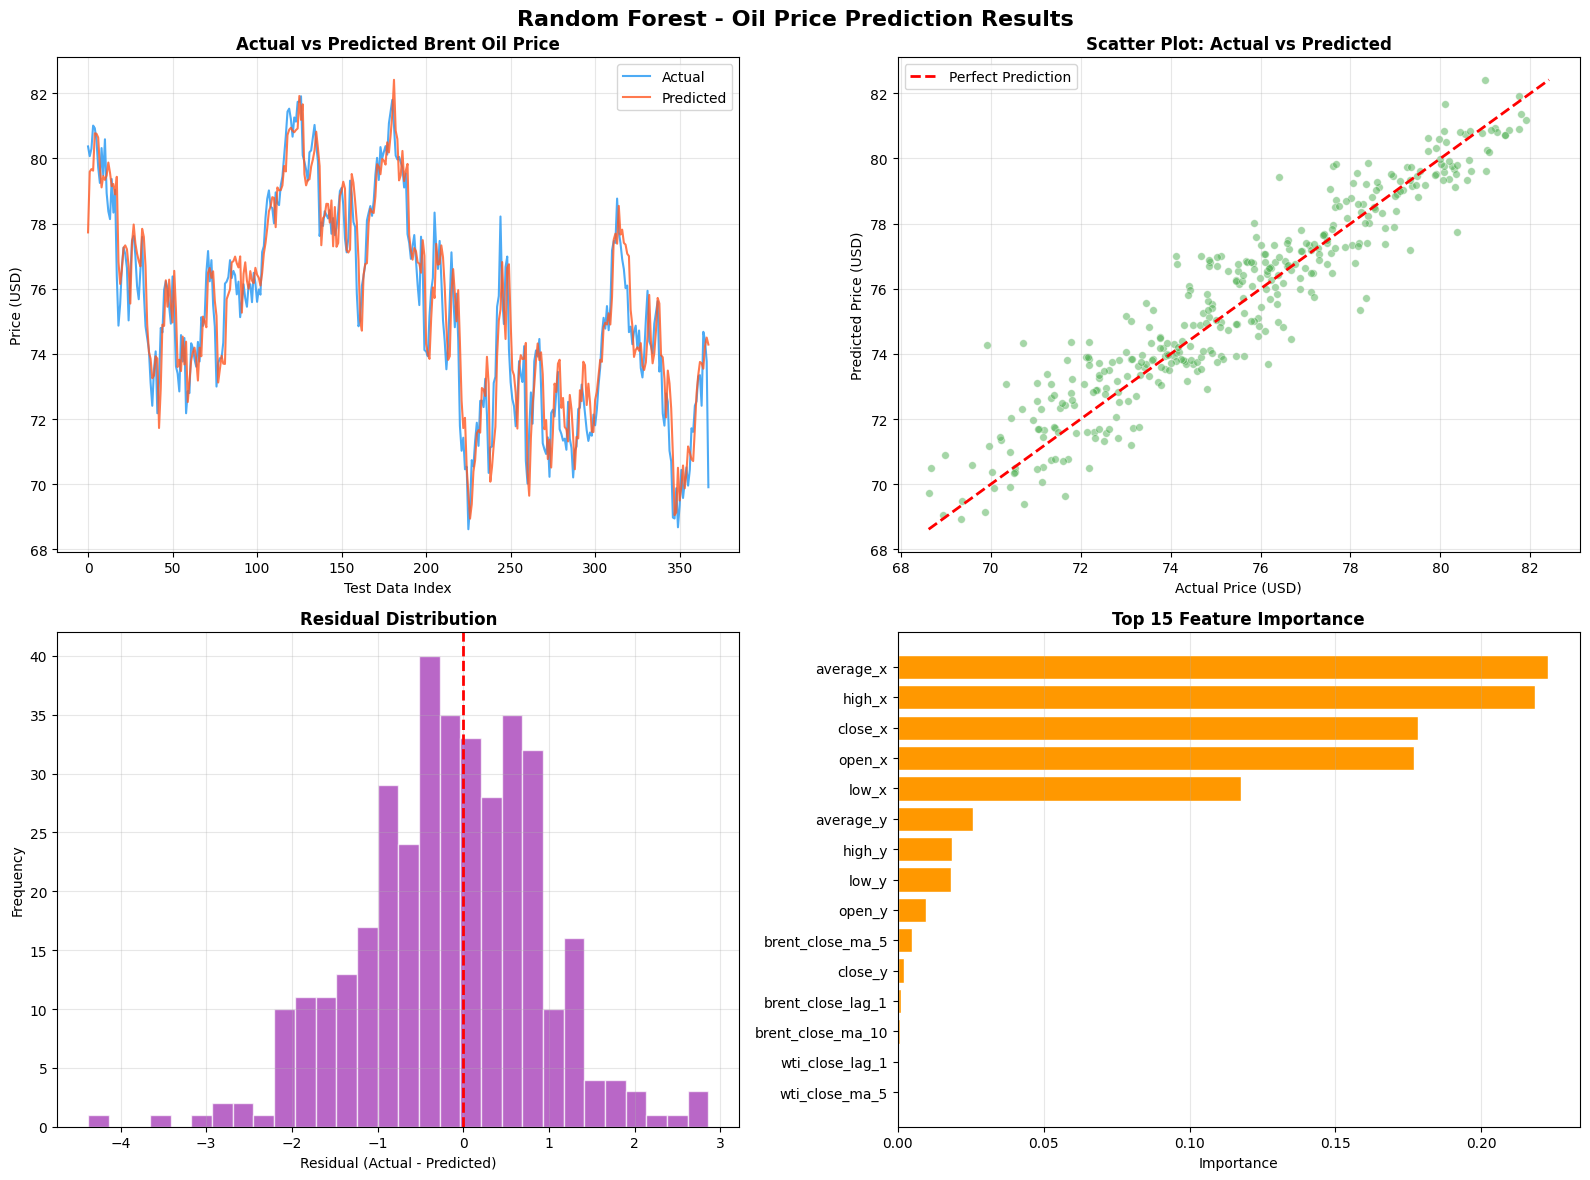

In [35]:
# --- 6.1 กราฟ Actual vs Predicted ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Random Forest - Oil Price Prediction Results', fontsize=16, fontweight='bold')
# Plot 1: Actual vs Predicted (Line)
ax1 = axes[0, 0]
ax1.plot(range(len(y_test)), y_test.values, label='Actual', color='#2196F3', linewidth=1.5, alpha=0.8)
ax1.plot(range(len(y_pred)), y_pred, label='Predicted', color='#FF5722', linewidth=1.5, alpha=0.8)
ax1.set_title('Actual vs Predicted Brent Oil Price', fontsize=12, fontweight='bold')
ax1.set_xlabel('Test Data Index')
ax1.set_ylabel('Price (USD)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Scatter Plot
ax2 = axes[0, 1]
ax2.scatter(y_test, y_pred, alpha=0.5, color='#4CAF50', edgecolors='white', linewidth=0.5, s=30)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_title('Scatter Plot: Actual vs Predicted', fontsize=12, fontweight='bold')
ax2.set_xlabel('Actual Price (USD)')
ax2.set_ylabel('Predicted Price (USD)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Residual Distribution
ax3 = axes[1, 0]
residuals = y_test.values - y_pred
ax3.hist(residuals, bins=30, color='#9C27B0', edgecolor='white', alpha=0.7)
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax3.set_title('Residual Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Residual (Actual - Predicted)')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

# Plot 4: Feature Importance (Top 15)
ax4 = axes[1, 1]
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values('Importance', ascending=True).tail(15)

ax4.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#FF9800', edgecolor='white')
ax4.set_title('Top 15 Feature Importance', fontsize=12, fontweight='bold')
ax4.set_xlabel('Importance')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(r"c:\Users\mawin\OneDrive\Desktop\project AI\rf_oil_prediction_results.png", dpi=150, bbox_inches='tight')
# plt.show()
print("\nบันทึกกราฟผลลัพธ์ที่: rf_oil_prediction_results.png")

# --- 6.2 Feature Importance ทั้งหมด ---
print("\n--- Feature Importance (เรียงจากมากไปน้อย) ---")
full_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values('Importance', ascending=False)
for i, row in full_importance.iterrows():
    print(f"  {row['Feature']:30s} : {row['Importance']:.6f}")


# 8. สรุปผลลัพธ์

In [32]:
print("\n" + "=" * 60)
print("  Part 8: สรุปผลลัพธ์")
print("=" * 60)

print(f"""
╔══════════════════════════════════════════════════════════╗
║           สรุปผลลัพธ์ Random Forest Model               ║
╠══════════════════════════════════════════════════════════╣
║                                                          ║
║  📊 ข้อมูลที่ใช้:                                        ║
║     - merged_oil_prices.csv (Brent + WTI)                ║
║     - brent_prices.csv                                   ║
║     - wti_prices.csv                                     ║
║     - จำนวนข้อมูลทั้งหมด : {len(df_clean):>6} rows                ║
║     - Training set       : {len(X_train):>6} rows ({len(X_train)/len(df_clean)*100:.0f}%)          ║
║     - Testing set        : {len(X_test):>6} rows ({len(X_test)/len(df_clean)*100:.0f}%)           ║
║                                                          ║
║  🔧 Model Configuration:                                ║
║     - Algorithm          : Random Forest Regressor       ║
║     - n_estimators       : 100                           ║
║     - max_depth          : None                          ║
║     - random_state       : 42                            ║
║     - จำนวน Features     : {len(feature_cols):>4}                       ║
║                                                          ║
║  📈 ผลการประเมิน:                                        ║
║     - MAE                : {mae:>10.4f} USD              ║
║     - MSE                : {mse:>10.4f}                  ║
║     - RMSE               : {rmse:>10.4f} USD             ║
║     - R² Score           : {r2:>10.4f}                   ║
║                                                          ║
║  🔮 ทำนายราคาวันถัดไป    : {prediction:>10.2f} USD              ║
║                                                          ║
╚══════════════════════════════════════════════════════════╝
""")

print("=" * 60)
print("  จบการทำงาน - Random Forest Oil Price Prediction")
print("=" * 60)


  Part 8: สรุปผลลัพธ์

╔══════════════════════════════════════════════════════════╗
║           สรุปผลลัพธ์ Random Forest Model               ║
╠══════════════════════════════════════════════════════════╣
║                                                          ║
║  📊 ข้อมูลที่ใช้:                                        ║
║     - merged_oil_prices.csv (Brent + WTI)                ║
║     - brent_prices.csv                                   ║
║     - wti_prices.csv                                     ║
║     - จำนวนข้อมูลทั้งหมด :   1836 rows                ║
║     - Training set       :   1468 rows (80%)          ║
║     - Testing set        :    368 rows (20%)           ║
║                                                          ║
║  🔧 Model Configuration:                                ║
║     - Algorithm          : Random Forest Regressor       ║
║     - n_estimators       : 100                           ║
║     - max_depth          : None                          ║
║     - rand